# Plotting 

In [ ]:

import os
import json
from glob import glob
from collections import defaultdict


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt

In [ ]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)


# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

## Figure Budget

In [ ]:


# [TODO] fix y-axis range to enable comparison across plots
def set_metric_ylim(ax, metric_key):
    """
    Set fixed y-axis limits for different metrics to ensure consistency across plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    if metric_key == 'PSNR':
        ax.set_ylim(24.5, 35.5)
    elif metric_key == 'SSIM':
        ax.set_ylim(0.8, 1.0)
    elif metric_key == 'LPIPS':
        ax.set_ylim(0, 0.2)

def budget_policy_curves():
    """
    Plot metrics vs budget for different budgeting policies.
    
    - Area-based budgeting - area_*_occlusion (0, 40k, 80k, 160k, 320k, 640k)
    - Distortion-based budgeting - distortion_*_occlusion (0, 40k, 80k, 160k, 320k, 640k)
    - Uniform budgeting - uniform_*_occlusion (0, 40k, 80k, 160k, 320k, 640k)
    """
    ITERATION = 'ours_15000'  # Last iteration for GS+Mesh
    MESH_ITERATION = 'ours_1'  # Pure mesh uses different key
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'budget_policy_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define policies and their budgets
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    # Quality Metrics to plot
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        # 'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'}
        # [TODO] draw LPIPS soon
    }
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key}")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline value - area_1_occlusion
        mesh_mean = None
        mesh_stderr = None
        
        mesh_file = input_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        print(f"\nChecking mesh file: {mesh_file}")
        print(f"File exists: {mesh_file.exists()}")
        
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            print(f"Available keys: {list(data.keys())}")
            
            # Try mesh iteration key first, then regular iteration key
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mesh_mean = np.mean(values)
                std_val = np.std(values)
                mesh_stderr = std_val / np.sqrt(len(values))
                
                print(f"Pure Mesh - {metric_key}: mean={mesh_mean:.4f}, std={std_val:.4f}, n={len(values)}")
            else:
                print(f"Neither {MESH_ITERATION} nor {ITERATION} found in mesh file")
        
        # 2. Area-based budgeting
        area_xs = []
        area_ys = []
        area_errs = []
        
        # Add pure mesh point at budget=0
        if mesh_mean is not None:
            area_xs.append(0)
            area_ys.append(mesh_mean)
            area_errs.append(mesh_stderr)
        
        print(f"\nProcessing Area-based budgeting:")
        for budget in budgets:
            area_file = input_dir / f'area_{budget}_occlusion' / 'per_view_gs_mesh.json'
            print(f"  Checking: {area_file.name}, exists: {area_file.exists()}")
            
            if area_file.exists():
                with open(area_file, 'r') as f:
                    data = json.load(f)
                
                if ITERATION in data:
                    metric_data = data[ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    num_splats = data[ITERATION].get('num_splats', budget)
                    
                    area_xs.append(num_splats)
                    area_ys.append(mean_val)
                    area_errs.append(stderr)
                    
                    print(f"    Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"    {ITERATION} not found in {area_file.name}")
        
        if area_xs:
            print(f"  Plotting {len(area_xs)} area points")
            ax.errorbar(area_xs, area_ys, yerr=area_errs,
                       marker='o', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[1], label='Area-based', zorder=2)
        else:
            print("  No area data to plot!")
        
        # 3. Distortion-based budgeting
        dist_xs = []
        dist_ys = []
        dist_errs = []
        
        # Add pure mesh point at budget=0
        if mesh_mean is not None:
            dist_xs.append(0)
            dist_ys.append(mesh_mean)
            dist_errs.append(mesh_stderr)
        
        print(f"\nProcessing Distortion-based budgeting:")
        for budget in budgets:
            dist_file = input_dir / f'distortion_{budget}_occlusion' / 'per_view_gs_mesh.json'
            print(f"  Checking: {dist_file.name}, exists: {dist_file.exists()}")
            
            if dist_file.exists():
                with open(dist_file, 'r') as f:
                    data = json.load(f)
                
                if ITERATION in data:
                    metric_data = data[ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    num_splats = data[ITERATION].get('num_splats', budget)
                    
                    dist_xs.append(num_splats)
                    dist_ys.append(mean_val)
                    dist_errs.append(stderr)
                    
                    print(f"    Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"    {ITERATION} not found in {dist_file.name}")
        
        if dist_xs:
            print(f"  Plotting {len(dist_xs)} distortion points")
            ax.errorbar(dist_xs, dist_ys, yerr=dist_errs,
                       marker='s', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[2], label='Distortion-based', zorder=2)
        else:
            print("  No distortion data to plot!")
        
        # 4. Uniform budgeting
        uniform_xs = []
        uniform_ys = []
        uniform_errs = []
        
        # Add pure mesh point at budget=0
        if mesh_mean is not None:
            uniform_xs.append(0)
            uniform_ys.append(mesh_mean)
            uniform_errs.append(mesh_stderr)
        
        print(f"\nProcessing Uniform budgeting:")
        for budget in budgets:
            uniform_file = input_dir / f'uniform_{budget}_occlusion' / 'per_view_gs_mesh.json'
            print(f"  Checking: {uniform_file.name}, exists: {uniform_file.exists()}")
            
            if uniform_file.exists():
                with open(uniform_file, 'r') as f:
                    data = json.load(f)
                
                if ITERATION in data:
                    metric_data = data[ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    num_splats = data[ITERATION].get('num_splats', budget)
                    
                    uniform_xs.append(num_splats)
                    uniform_ys.append(mean_val)
                    uniform_errs.append(stderr)
                    
                    print(f"    Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"    {ITERATION} not found in {uniform_file.name}")
        
        if uniform_xs:
            print(f"  Plotting {len(uniform_xs)} uniform points")
            ax.errorbar(uniform_xs, uniform_ys, yerr=uniform_errs,
                       marker='.', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[3], label='Uniform', zorder=2)
        else:
            print("  No uniform data to plot!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        # ax.set_title(f"{metric_info['title']} vs. Budget ({SCENE_NAME})", fontsize=22)
        
        # Set fixed y-axis range
        set_metric_ylim(ax, metric_key)
        
        # ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_vs_budget_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()

SCENE_NAME = 'ship'

budget_policy_curves()

## Figure Delta (DTGS - Pure Mesh)

In [ ]:
# [TODO] two figures (PSNR/SSIM) average of all scenes

## Figure Iter


Plotting PSNR vs Iteration

Processing Area-based budgeting:
  File: per_view_gs_mesh.json, exists: True
    Iter 1000: mean=30.0931, std=2.1898, n=200
    Iter 2000: mean=30.4999, std=2.2684, n=200
    Iter 3000: mean=31.3360, std=2.2305, n=200
    Iter 4000: mean=31.7284, std=2.2397, n=200
    Iter 5000: mean=31.9055, std=2.2287, n=200
    Iter 6000: mean=32.0250, std=2.2076, n=200
    Iter 7000: mean=32.1165, std=2.1789, n=200
    Iter 10000: mean=32.3154, std=2.1152, n=200
    Iter 12000: mean=32.4157, std=2.0756, n=200
    Iter 15000: mean=32.5369, std=2.0155, n=200
  Plotting 10 area points

Processing Distortion-based budgeting:
  File: per_view_gs_mesh.json, exists: True
    Iter 1000: mean=30.2547, std=2.4771, n=200
    Iter 2000: mean=30.6814, std=2.5842, n=200
    Iter 3000: mean=31.7380, std=2.5757, n=200
    Iter 4000: mean=32.2484, std=2.6134, n=200
    Iter 5000: mean=32.4468, std=2.5969, n=200
    Iter 6000: mean=32.5917, std=2.5777, n=200
    Iter 7000: mean=32.7067, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: PSNR_vs_iteration_hotdog_budget160k.png and .eps



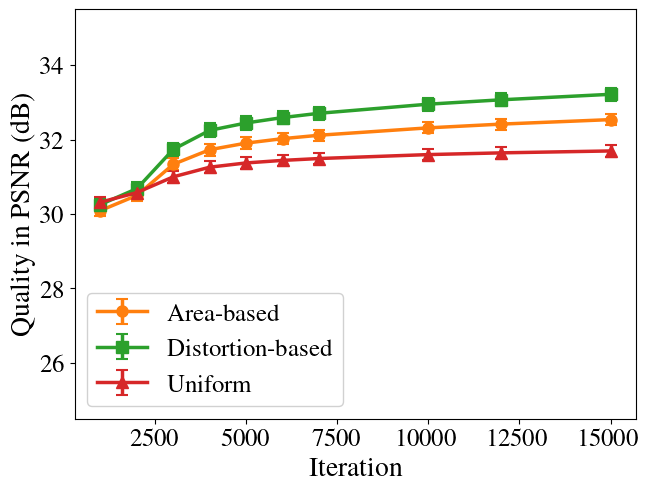


Plotting SSIM vs Iteration

Processing Area-based budgeting:
  File: per_view_gs_mesh.json, exists: True
    Iter 1000: mean=0.9596, std=0.0050, n=200
    Iter 2000: mean=0.9626, std=0.0044, n=200
    Iter 3000: mean=0.9658, std=0.0045, n=200
    Iter 4000: mean=0.9675, std=0.0045, n=200
    Iter 5000: mean=0.9679, std=0.0046, n=200
    Iter 6000: mean=0.9682, std=0.0046, n=200
    Iter 7000: mean=0.9684, std=0.0047, n=200
    Iter 10000: mean=0.9685, std=0.0048, n=200
    Iter 12000: mean=0.9686, std=0.0049, n=200
    Iter 15000: mean=0.9687, std=0.0050, n=200
  Plotting 10 area points

Processing Distortion-based budgeting:
  File: per_view_gs_mesh.json, exists: True
    Iter 1000: mean=0.9623, std=0.0041, n=200
    Iter 2000: mean=0.9653, std=0.0038, n=200
    Iter 3000: mean=0.9685, std=0.0037, n=200
    Iter 4000: mean=0.9702, std=0.0038, n=200
    Iter 5000: mean=0.9707, std=0.0038, n=200
    Iter 6000: mean=0.9710, std=0.0038, n=200
    Iter 7000: mean=0.9712, std=0.0037, n=200

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: SSIM_vs_iteration_hotdog_budget160k.png and .eps



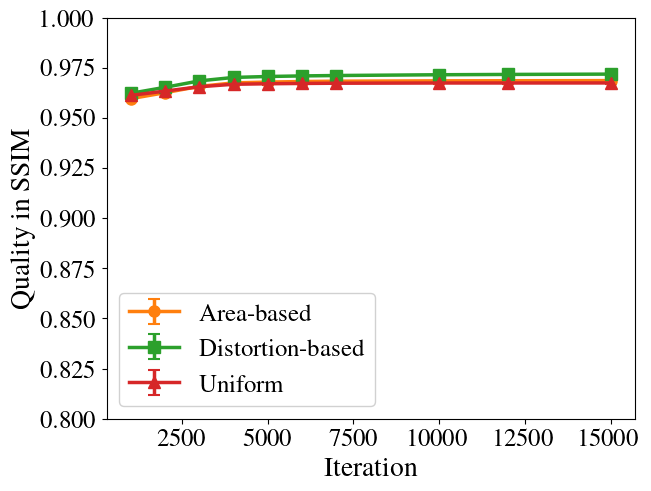

In [11]:

def set_metric_ylim(ax, metric_key):
    """
    Set fixed y-axis limits for different metrics to ensure consistency across plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    if metric_key == 'PSNR':
        ax.set_ylim(24.5, 35.5)
    elif metric_key == 'SSIM':
        ax.set_ylim(0.8, 1.0)
    elif metric_key == 'LPIPS':
        ax.set_ylim(0, 0.2)

def policy_iter_curves():
    """
    Plot metrics vs iteration for different budgeting policies at fixed budget (160k).
    
    x-axis: iteration number (1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000)
    y-axis: quality in PSNR/SSIM/LPIPS
    
    - Area-based budgeting - area_160000_occlusion
    - Distortion-based budgeting - distortion_160000_occlusion
    - Uniform budgeting - uniform_160000_occlusion
    """
    BUDGET = 160000  # Fixed budget
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'policy_iter_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define iterations to plot
    iterations = ['ours_1000', 'ours_2000', 'ours_3000', 'ours_4000', 'ours_5000', 
                  'ours_6000', 'ours_7000', 'ours_10000', 'ours_12000', 'ours_15000']
    iter_nums = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000]
    
    # Quality Metrics to plot
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        # 'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'}
    }
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key} vs Iteration")
        print(f"{'='*60}")
        
        # 1. Area-based budgeting
        area_xs = []
        area_ys = []
        area_errs = []
        
        area_file = input_dir / f'area_{BUDGET}_occlusion' / 'per_view_gs_mesh.json'
        print(f"\nProcessing Area-based budgeting:")
        print(f"  File: {area_file.name}, exists: {area_file.exists()}")
        
        if area_file.exists():
            with open(area_file, 'r') as f:
                data = json.load(f)
            
            for iter_key, iter_num in zip(iterations, iter_nums):
                if iter_key in data:
                    metric_data = data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    
                    area_xs.append(iter_num)
                    area_ys.append(mean_val)
                    area_errs.append(stderr)
                    
                    print(f"    Iter {iter_num}: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
                else:
                    print(f"    Iter {iter_num}: {iter_key} not found")
        
        if area_xs:
            print(f"  Plotting {len(area_xs)} area points")
            ax.errorbar(area_xs, area_ys, yerr=area_errs,
                       marker='o', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[1], label='Area-based', zorder=2)
        
        # 2. Distortion-based budgeting
        dist_xs = []
        dist_ys = []
        dist_errs = []
        
        dist_file = input_dir / f'distortion_{BUDGET}_occlusion' / 'per_view_gs_mesh.json'
        print(f"\nProcessing Distortion-based budgeting:")
        print(f"  File: {dist_file.name}, exists: {dist_file.exists()}")
        
        if dist_file.exists():
            with open(dist_file, 'r') as f:
                data = json.load(f)
            
            for iter_key, iter_num in zip(iterations, iter_nums):
                if iter_key in data:
                    metric_data = data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    
                    dist_xs.append(iter_num)
                    dist_ys.append(mean_val)
                    dist_errs.append(stderr)
                    
                    print(f"    Iter {iter_num}: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
                else:
                    print(f"    Iter {iter_num}: {iter_key} not found")
        
        if dist_xs:
            print(f"  Plotting {len(dist_xs)} distortion points")
            ax.errorbar(dist_xs, dist_ys, yerr=dist_errs,
                       marker='s', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[2], label='Distortion-based', zorder=2)
        
        # 3. Uniform budgeting
        uniform_xs = []
        uniform_ys = []
        uniform_errs = []
        
        uniform_file = input_dir / f'uniform_{BUDGET}_occlusion' / 'per_view_gs_mesh.json'
        print(f"\nProcessing Uniform budgeting:")
        print(f"  File: {uniform_file.name}, exists: {uniform_file.exists()}")
        
        if uniform_file.exists():
            with open(uniform_file, 'r') as f:
                data = json.load(f)
            
            for iter_key, iter_num in zip(iterations, iter_nums):
                if iter_key in data:
                    metric_data = data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    
                    uniform_xs.append(iter_num)
                    uniform_ys.append(mean_val)
                    uniform_errs.append(stderr)
                    
                    print(f"    Iter {iter_num}: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
                else:
                    print(f"    Iter {iter_num}: {iter_key} not found")
        
        if uniform_xs:
            print(f"  Plotting {len(uniform_xs)} uniform points")
            ax.errorbar(uniform_xs, uniform_ys, yerr=uniform_errs,
                       marker='^', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[3], label='Uniform', zorder=2)
        
        # Formatting
        ax.set_xlabel('Iteration', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # Set fixed y-axis range
        set_metric_ylim(ax, metric_key)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_vs_iteration_{SCENE_NAME}_budget{BUDGET//1000}k'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()



SCENE_NAME = 'hotdog'
policy_iter_curves()